In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
import scipy.io
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F



seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

g = 9.81

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Utilizando o dispositivo:', device)

Utilizando o dispositivo: cpu


In [3]:
# Valores numéricos

mu_v = 1
zeta_v = 0.05
k_v = 1
gamma_v = 0.1
P_v = 0.08

In [4]:
A_dir = "/Users/catarinabarros/Documents/GitHub/PhysicsInformedNN/Dataset/A_dataset.txt"
B_dir = "/Users/catarinabarros/Documents/GitHub/PhysicsInformedNN/Dataset/B_dataset.txt"
Af_dir = "/Users/catarinabarros/Documents/GitHub/PhysicsInformedNN/Dataset/Af_dataset.txt"
Bf_dir = "/Users/catarinabarros/Documents/GitHub/PhysicsInformedNN/Dataset/Bf_dataset.txt"
X_dir = "/Users/catarinabarros/Documents/GitHub/PhysicsInformedNN/Dataset/X_dataset.txt"

In [5]:
A =np.loadtxt(A_dir)
B = np.loadtxt(B_dir)
Af = np.loadtxt(Af_dir)
Bf = np.loadtxt(Bf_dir)

X = np.loadtxt(X_dir)
X = 2*np.pi*X

In [6]:
A.shape, X.shape

((5174,), (5174,))

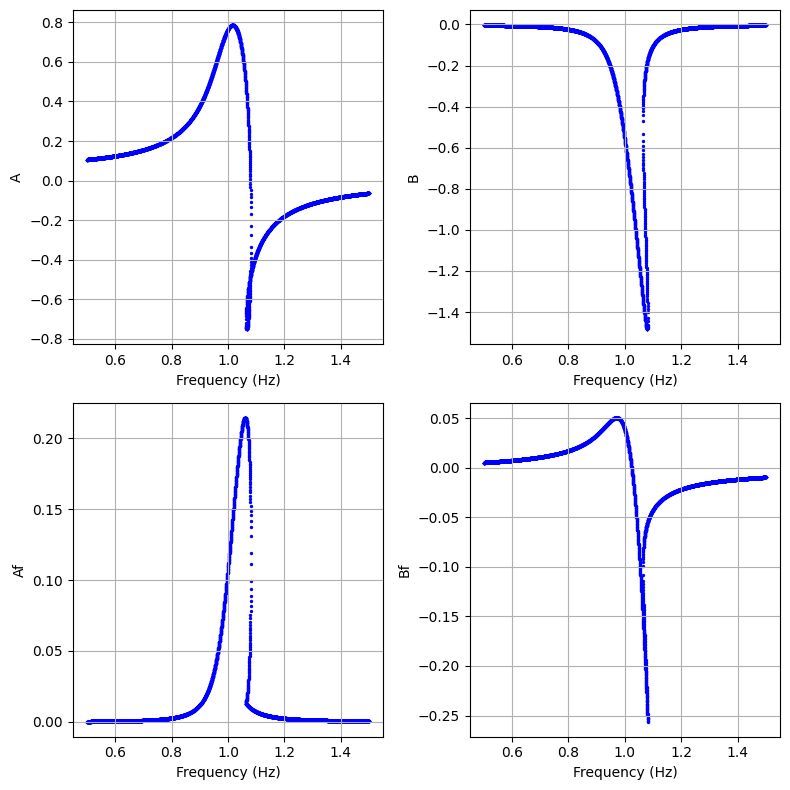

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))


axes[0, 0].scatter(X, A, color='blue', s=2)
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('A')
axes[0, 0].grid(True)



axes[0, 1].scatter(X, B, color='blue', s=2)
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('B')
axes[0, 1].grid(True)



axes[1, 0].scatter(X, Af, color='blue', s=2)
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Af')
axes[1, 0].grid(True)


axes[1, 1].scatter(X, Bf, color='blue', s=2)
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Bf')
axes[1, 1].grid(True)


plt.tight_layout()
plt.show();


In [8]:
X_train, X_test, train_idx, test_idx = train_test_split(X, np.arange(X.shape[0]), test_size=0.2, random_state=seed)

# Usar os índices para dividir A, B, Af e Bf
A_train, A_test = A[train_idx], A[test_idx]
B_train, B_test = B[train_idx], B[test_idx]
Af_train, Af_test = Af[train_idx], Af[test_idx]
Bf_train, Bf_test = Bf[train_idx], Bf[test_idx]

In [9]:
# Inicialize o MinMaxScaler
scaler_A = MinMaxScaler()
scaler_B = MinMaxScaler()
scaler_Af = MinMaxScaler()
scaler_Bf = MinMaxScaler()

# Redefina os dados para 2D, se necessário (aqui já está 2D conforme sua reshape)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
A_train = A_train.reshape(-1, 1)
A_test = A_test.reshape(-1, 1)
B_train = B_train.reshape(-1, 1)
B_test = B_test.reshape(-1, 1)
Af_train = Af_train.reshape(-1, 1)
Af_test = Af_test.reshape(-1, 1)
Bf_train = Bf_train.reshape(-1, 1)
Bf_test = Bf_test.reshape(-1, 1)

# Normalize os dados
A_train = scaler_A.fit_transform(A_train)
A_test = scaler_A.transform(A_test)

B_train = scaler_B.fit_transform(B_train)
B_test = scaler_B.transform(B_test)

Af_train = scaler_Af.fit_transform(Af_train)
Af_test = scaler_Af.transform(Af_test)

Bf_train = scaler_Bf.fit_transform(Bf_train)
Bf_test = scaler_Bf.transform(Bf_test)

# Converta arrays numpy normalizados para tensores PyTorch
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

A_train = torch.from_numpy(A_train.astype(np.float32))
A_test = torch.from_numpy(A_test.astype(np.float32))

B_train = torch.from_numpy(B_train.astype(np.float32))
B_test = torch.from_numpy(B_test.astype(np.float32))

Af_train = torch.from_numpy(Af_train.astype(np.float32))
Af_test = torch.from_numpy(Af_test.astype(np.float32))

Bf_train = torch.from_numpy(Bf_train.astype(np.float32))
Bf_test = torch.from_numpy(Bf_test.astype(np.float32))

# Se necessário, mova os dados para a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)
X_test = X_test.to(device)
A_train = A_train.to(device)
A_test = A_test.to(device)

B_train = B_train.to(device)
B_test = B_test.to(device)

Af_train = Af_train.to(device)
Af_test = Af_test.to(device)

Bf_train = Bf_train.to(device)
Bf_test = Bf_test.to(device)

##  Neural networks

In [10]:
class A_NN(nn.Module):
      def __init__(self, input_size, output_size):
            super(A_NN, self).__init__()
            self.fc1 = nn.Linear(input_size, 20)
            self.fc2 = nn.Linear(20,15)
            self.fc3 = nn.Linear(15,15)
            self.output = nn.Linear(15, output_size)

      def forward(self, x):
            x = torch.tanh(self.fc1(x))
            x = torch.tanh(self.fc2(x))
            #x= torch.tanh(self.fc3(x))
            x = self.output(x)
            return x   


In [11]:
class B_NN(nn.Module):
    def __init__(self, input_size, output_size):
            super(B_NN, self).__init__()
            self.fc1 = nn.Linear(input_size, 20)
            self.fc2 = nn.Linear(20,15)
            self.fc3 = nn.Linear(15,15)
            self.output = nn.Linear(15, output_size)

    def forward(self, x):
            x = torch.tanh(self.fc1(x))
            x = torch.tanh(self.fc2(x))
            #x= torch.tanh(self.fc3(x))
            x = self.output(x)
            return x  


In [12]:
class Af_NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(Af_NN, self).__init__()
        self.fc1 = nn.Linear(3 * input_size, 15)  # Update input size to accept concatenated inputs
        self.fc2 = nn.Linear(15,15)
        #self.fc3 = nn.Linear(15,15)
        self.output = nn.Linear(15, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        #x= torch.tanh(self.fc3(x))
        x = self.output(x)
        return x

In [13]:
class Bf_NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(Bf_NN, self).__init__()
        self.fc1 = nn.Linear(3 * input_size, 15)  # Update input size to accept concatenated inputs
        self.fc2 = nn.Linear(15,15)
        self.fc3 = nn.Linear(15,15)
        self.output = nn.Linear(15, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        #x= torch.tanh(self.fc3(x))
        x = self.output(x)
        return x

### Loss functions

In [14]:
def add_noise(loss, noise_level=0.01):
    noise = noise_level * torch.randn_like(loss)
    return loss + noise

# Atualização das funções de perda com ruído
def loss_sin(X_array, A_pred, B_pred, Bf_pred, noise_level=0.01):
    loss = -mu_v * B_pred * X_array**2 - zeta_v * A_pred * X_array + k_v * B_pred + Bf_pred
    noisy_loss = add_noise(loss, noise_level)
    return torch.mean(torch.abs(noisy_loss))

def loss_cos(X_array, A_pred, B_pred, Af_pred, noise_level=0.01):
    loss = -mu_v * A_pred * X_array**2 + zeta_v * B_pred * X_array + k_v * A_pred + Af_pred - P_v
    noisy_loss = add_noise(loss, noise_level)
    return torch.mean(torch.abs(noisy_loss))

def calculate_mse_loss(A_pred, B_pred, Af_pred, Bf_pred, A_true, B_true, Af_true, Bf_true, noise_level=0.01):
    mse_loss_A = F.mse_loss(A_pred, A_true)
    mse_loss_B = F.mse_loss(B_pred, B_true)
    mse_loss_Af = F.mse_loss(Af_pred, Af_true)
    mse_loss_Bf = F.mse_loss(Bf_pred, Bf_true)
    total_mse_loss = mse_loss_A + mse_loss_B + mse_loss_Af + mse_loss_Bf
    noisy_loss = add_noise(total_mse_loss, noise_level)
    return noisy_loss

In [15]:
input_size = 1  # Ajuste conforme necessário
output_size = 1  # Ajuste conforme necessário

A_model = A_NN(input_size, output_size)
B_model = B_NN(input_size, output_size)
Af_model = Af_NN(input_size, output_size)
Bf_model = Bf_NN(input_size, output_size)

# Definindo os parâmetros dos modelos
params = (
    list(A_model.parameters()) +
    list(B_model.parameters()) +
    list(Af_model.parameters()) +
    list(Bf_model.parameters())
)

num_epochs = int(1e3)
batch_size = 32
steps_per_epoch = (len(X_train) + batch_size - 1) // batch_size

# Definindo o otimizador único
learning_rate = 0.001
optimizer = optim.Adam(params, lr=learning_rate)

# Definindo o scheduler OneCycleLR
scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch, pct_start=0.5, anneal_strategy='cos', cycle_momentum=False)


In [16]:

A_train = A_train.to(device)
Af_train = Af_train.to(device)
B_train = B_train.to(device)
Bf_train = Bf_train.to(device)
#t = t.to(device)
X_train = X_train.to(device)
X_test = X_test.to(device)

A_model = A_model.to(device)
Af_model = Af_model.to(device)
B_model = B_model.to(device)
Bf_model = Bf_model.to(device)

In [17]:
loss_array = []
loss_sin_array = []
loss_cos_array = []
loss_mse_array = []

learning_rates = []

coef_sin = 0
coef_cos = 0
coef_mse = 1


total_steps = steps_per_epoch * num_epochs * batch_size

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        if total_steps <= 0:
            break
        X_batch = X_train[i:i + batch_size]
        A_batch = A_train[i:i + batch_size]
        Af_batch = Af_train[i:i + batch_size]
        B_batch = B_train[i:i + batch_size]
        Bf_batch = Bf_train[i:i + batch_size]

        A_predicted = A_model(X_batch)
        B_predicted = B_model(X_batch)

        Af_input = torch.cat((X_batch, A_predicted, B_predicted), dim=1)
        Bf_input = torch.cat((X_batch, A_predicted, B_predicted), dim=1)

        Af_predicted = Af_model(Af_input)
        Bf_predicted = Bf_model(Bf_input)

        loss_sin_v = coef_sin * loss_sin(X_batch, A_predicted, B_predicted, Bf_predicted)
        loss_cos_v = coef_cos * loss_cos(X_batch, A_predicted, B_predicted, Af_predicted)
        loss_mse_v = coef_mse * calculate_mse_loss(A_predicted, B_predicted, Af_predicted, Bf_predicted, A_batch, B_batch, Af_batch, Bf_batch)

        loss = coef_mse * loss_mse_v + coef_sin * loss_sin_v + coef_cos * loss_cos_v

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_steps -= 1

    loss_array.append(loss.item())
    loss_sin_array.append(loss_sin_v.item())
    loss_cos_array.append(loss_cos_v.item())
    loss_mse_array.append(loss_mse_v.item())
    learning_rates.append(optimizer.param_groups[0]['lr'])

    if (epoch + 1) % 10 == 0:
        print(f'#### epoch: {epoch + 1}, loss = {loss.item()} ####')
        print("Loss Sin: ", loss_sin_v.item())
        print("Loss Cos: ", loss_cos_v.item())
        print("Loss MSE: ", loss_mse_v.item())


#### epoch: 10, loss = 0.12057188898324966 ####
Loss Sin:  0.0
Loss Cos:  0.0
Loss MSE:  0.12057188898324966
#### epoch: 20, loss = 0.10092814266681671 ####
Loss Sin:  0.0
Loss Cos:  0.0
Loss MSE:  0.10092814266681671
#### epoch: 30, loss = 0.1033109650015831 ####
Loss Sin:  0.0
Loss Cos:  0.0
Loss MSE:  0.1033109650015831
#### epoch: 40, loss = 0.10596571117639542 ####
Loss Sin:  0.0
Loss Cos:  0.0
Loss MSE:  0.10596571117639542
#### epoch: 50, loss = 0.12142723798751831 ####
Loss Sin:  0.0
Loss Cos:  0.0
Loss MSE:  0.12142723798751831
#### epoch: 60, loss = 0.0952131599187851 ####
Loss Sin:  0.0
Loss Cos:  0.0
Loss MSE:  0.0952131599187851
#### epoch: 70, loss = 0.11524920165538788 ####
Loss Sin:  0.0
Loss Cos:  0.0
Loss MSE:  0.11524920165538788
#### epoch: 80, loss = 0.11048244684934616 ####
Loss Sin:  0.0
Loss Cos:  0.0
Loss MSE:  0.11048244684934616
#### epoch: 90, loss = 0.11277417093515396 ####
Loss Sin:  0.0
Loss Cos:  0.0
Loss MSE:  0.11277417093515396
#### epoch: 100, loss =

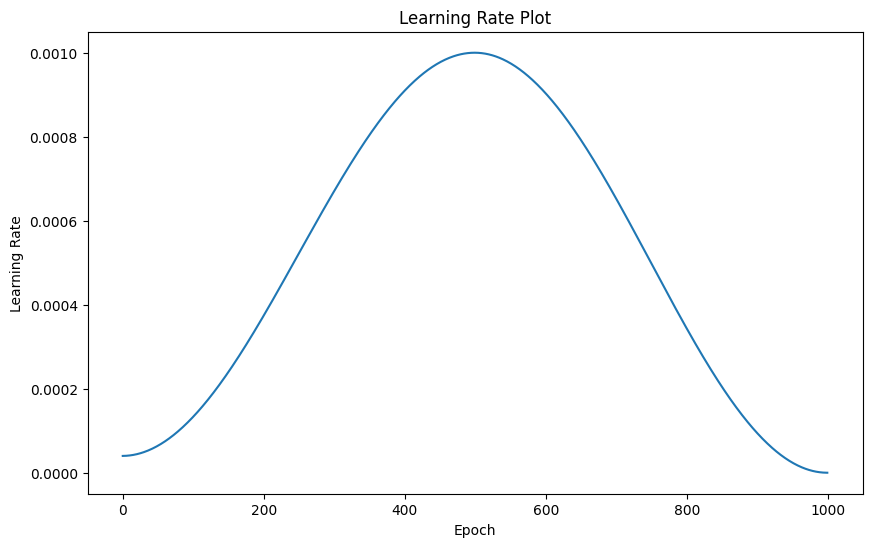

In [18]:
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(learning_rates)

# Set the title and labels
plt.title('Learning Rate Plot')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

# Show the plot
plt.show()

Total Loss: 0.023022601380944252
Sin Loss: 0.0
Cos Loss: 0.0
MSE Loss: 0.023022601380944252


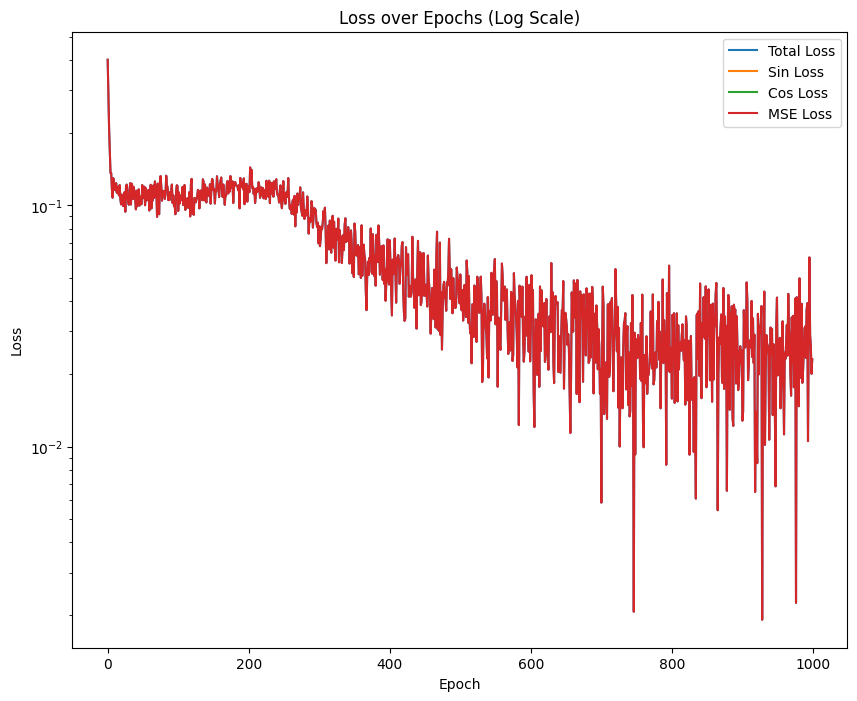

In [19]:
plt.figure(figsize=(10, 8))

# Plotando todas as perdas no mesmo gráfico
plt.plot(loss_array, label='Total Loss')
plt.plot(loss_sin_array, label='Sin Loss')
plt.plot(loss_cos_array, label='Cos Loss')
plt.plot(loss_mse_array, label='MSE Loss')

# Configurando o gráfico
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss over Epochs (Log Scale)')
plt.legend()  # Adiciona a legenda

# Exibindo o último valor de loss
print(f'Total Loss: {loss_array[-1]}')
print(f'Sin Loss: {loss_sin_array[-1]}')
print(f'Cos Loss: {loss_cos_array[-1]}')
print(f'MSE Loss: {loss_mse_array[-1]}')

# Exibindo o gráfico
plt.show()


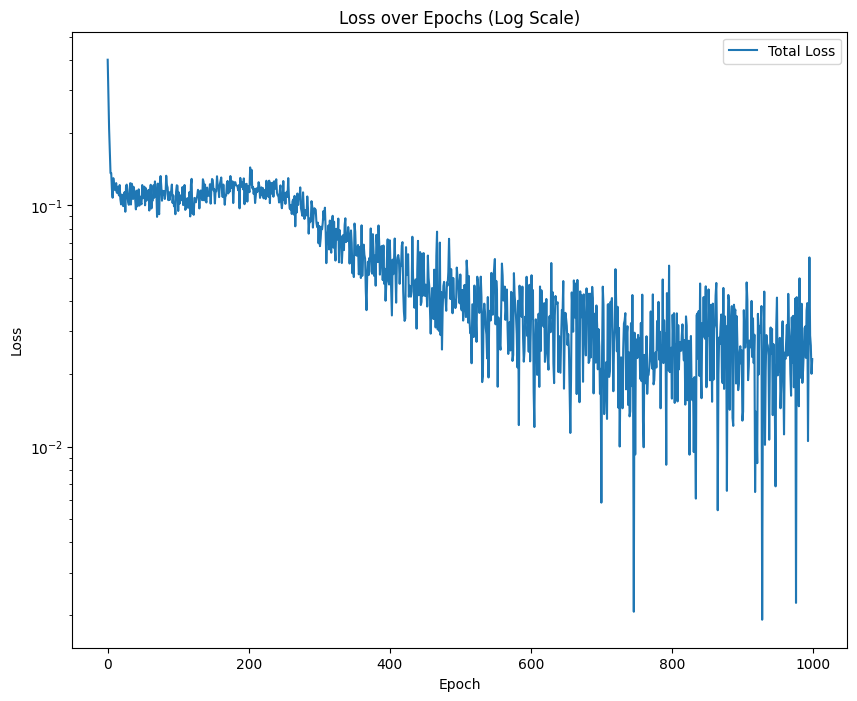

In [20]:
plt.figure(figsize=(10, 8))

# Plotando todas as perdas no mesmo gráfico
plt.plot(loss_array, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss over Epochs (Log Scale)')
#plt.xlim(400,500)
plt.legend()  # Adiciona a legenda

plt.show()

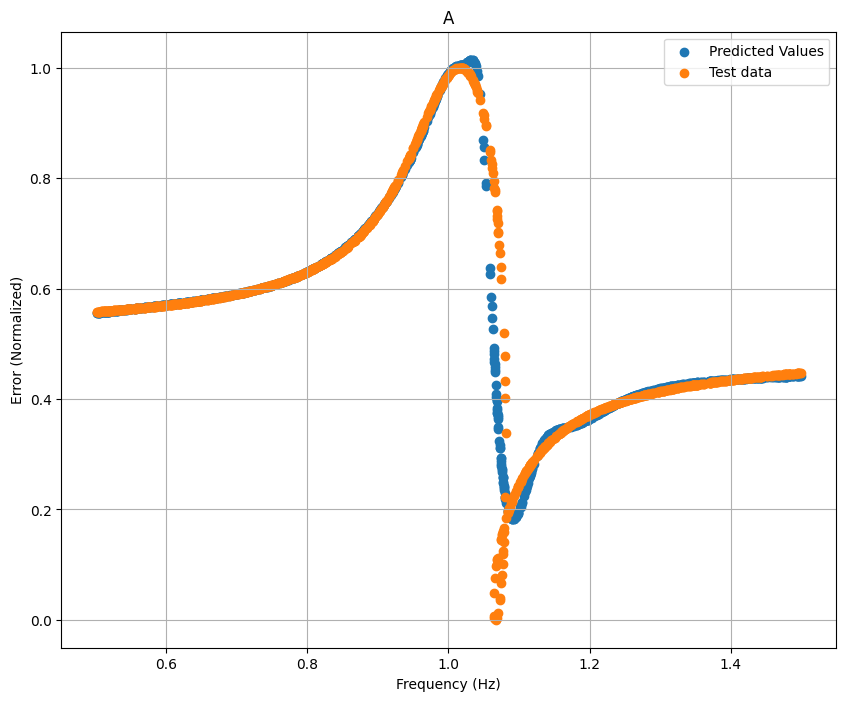

In [21]:
# Predição
A_predicted = A_model(X_test).detach().cpu().numpy()



# Plotagem
plt.figure(figsize=(10, 8))
plt.scatter(X_test.cpu().numpy(), A_predicted, label="Predicted Values")  # Converta X_test para numpy
plt.scatter(X_test.cpu().numpy(), A_test.cpu().numpy(), label="Test data")  # Converta A_test para numpy
plt.xlabel('Frequency (Hz)')
plt.ylabel('Error (Normalized)')
plt.title("A")
plt.grid(True)
plt.legend()
plt.show()


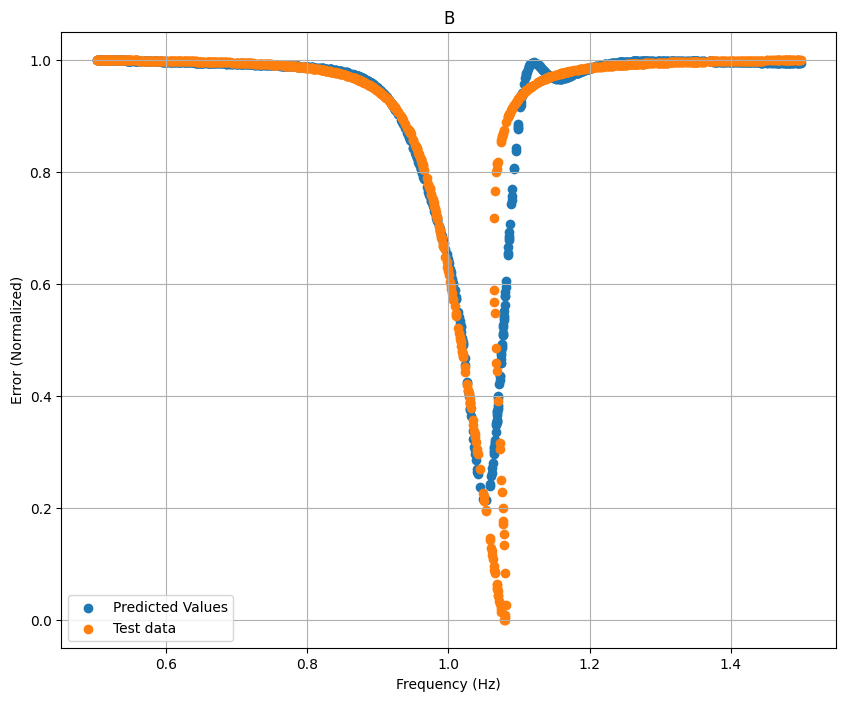

In [22]:
# Predição
B_predicted = B_model(X_test).detach().cpu().numpy()

# Plotagem
plt.figure(figsize=(10, 8))
plt.scatter(X_test.cpu().numpy(), B_predicted, label="Predicted Values")  # Converta X_test para numpy
plt.scatter(X_test.cpu().numpy(), B_test.cpu().numpy(), label="Test data")  # Converta A_test para numpy
plt.xlabel('Frequency (Hz)')
plt.ylabel('Error (Normalized)')
plt.title("B")
plt.grid(True)
plt.legend()
plt.show()


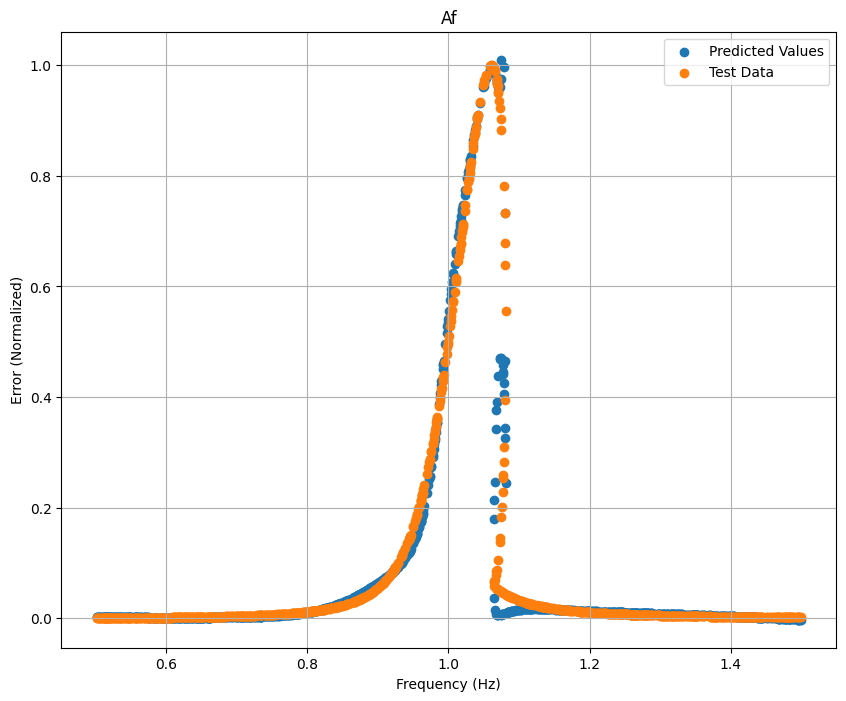

In [23]:
 #Obtendo as predições de B_model e A_model
B_predicted = B_model(X_test).detach().cpu()
A_predicted = A_model(X_test).detach().cpu()

# Coloca o modelo Af_model em modo de avaliação
Af_model.eval()

# Desabilita o cálculo do gradiente
with torch.no_grad():
    # Cria as entradas para Af_model e move para o mesmo dispositivo
    X_test = X_test.to(device)
    A_test = A_test.to(device)
    B_test = B_test.to(device)
    Af_pred_input = torch.cat((X_test, A_test, B_test), dim=1).to(device)

    # Realiza a predição e converte para numpy
    Af_predicted = Af_model(Af_pred_input).detach().cpu().numpy()

# Plotagem
plt.figure(figsize=(10, 8))

# Converta X_test e Af_test para numpy se ainda não estiverem
X_test_np = X_test.cpu().numpy() if not isinstance(X_test, np.ndarray) else X_test
Af_test_np = Af_test.cpu().numpy() if not isinstance(Af_test, np.ndarray) else Af_test

plt.scatter(X_test_np, Af_predicted, label="Predicted Values")
plt.scatter(X_test_np, Af_test_np, label="Test Data")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Error (Normalized)')
plt.title("Af")
plt.grid(True)
plt.legend()
plt.show()

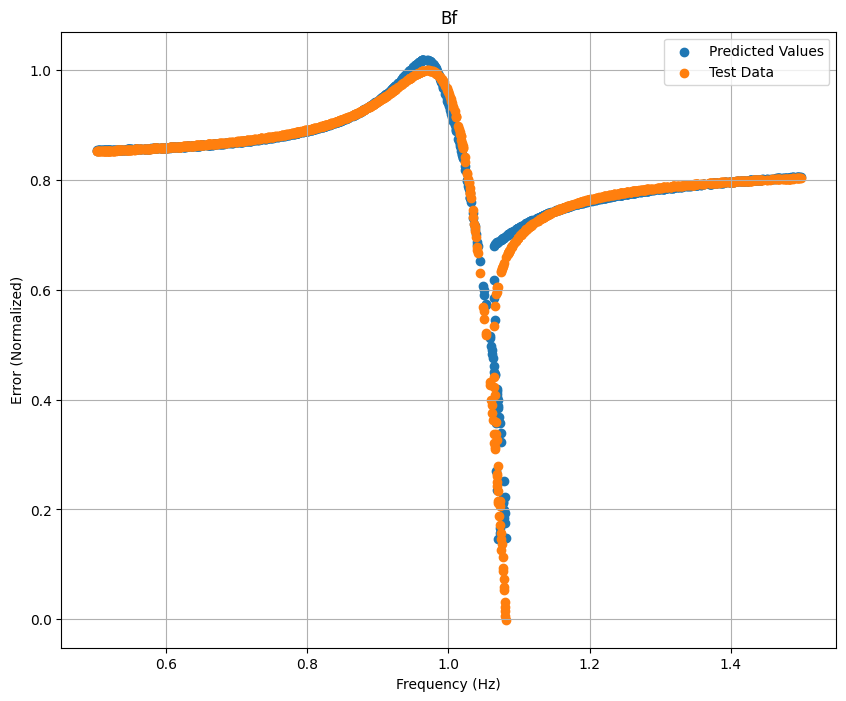

In [24]:
Bf_model.eval()

# Desabilita o cálculo do gradiente
with torch.no_grad():
    # Cria as entradas para Bf_model e move para o mesmo dispositivo
    Bf_pred_input = torch.cat((X_test, A_test, B_test), dim=1)

    # Realiza a predição e converte para numpy
    Bf_predicted = Bf_model(Bf_pred_input).detach().cpu().numpy()


# Plotagem
plt.figure(figsize=(10, 8))

# Converte X_test e Bf_test para numpy se ainda não estiverem
X_test_np = X_test.cpu().numpy() if not isinstance(X_test, np.ndarray) else X_test
Bf_test_np = Bf_test.cpu().numpy() if not isinstance(Bf_test, np.ndarray) else Bf_test

plt.scatter(X_test_np, Bf_predicted, label="Predicted Values")
plt.scatter(X_test_np, Bf_test_np, label="Test Data")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Error (Normalized)')
plt.title("Bf")
plt.grid(True)
plt.legend()
plt.show()